# Setup

In [2]:
#import libraries and set up matplotlib
import pandas as pd
import os
import math
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(font_scale=1.5)
plt.rcParams['figure.figsize']=(6,4)
plt.rcParams['font.size']=14

/Users/michaeltwardos/anaconda/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')
/Users/michaeltwardos/anaconda/lib/python2.7/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


In [4]:
#get data
os.chdir('/Users/michaeltwardos/Desktop/Asana/') #PLEASE SET THIS WORKING DIRECTORY TO YOURS
data = pd.read_csv('asana_users.csv')
data.head()

,user_id,mailing_list,drip,creation_source,invited,first_seven,any_seven
0,1,1,0,GUEST_INVITE,1,0,0
1,2,0,0,ORG_INVITE,1,0,1
2,3,0,0,ORG_INVITE,1,0,0
3,4,0,0,GUEST_INVITE,1,0,0
4,5,0,0,GUEST_INVITE,1,0,0


In [5]:
# turn creation source categorical variable into indicator variables
creation_source = pd.get_dummies(data['creation_source'])
data = pd.concat([data, creation_source], axis=1)    
del data['creation_source']
data.head()

,user_id,mailing_list,drip,invited,first_seven,any_seven,GUEST_INVITE,ORG_INVITE,PERSONAL_PROJECTS,SIGNUP,SIGNUP_GOOGLE_AUTH
0,1,1,0,1,0,0,1,0,0,0,0
1,2,0,0,1,0,1,0,1,0,0,0
2,3,0,0,1,0,0,0,1,0,0,0
3,4,0,0,1,0,0,1,0,0,0,0
4,5,0,0,1,0,0,1,0,0,0,0


In [12]:
# PERSONAL_PROJECTS creation_source has the largest magnitude correlation with an adopted user but it is negative.  
# GUEST_INVITE followed by invited has the highest correlation that is positive.
data.corr()['PERSONAL_PROJECTS']

user_id              -0.003357
mailing_list         -0.007432
drip                 -0.007518
invited              -0.495336
first_seven          -0.016152
any_seven            -0.075817
GUEST_INVITE         -0.216653
ORG_INVITE           -0.342395
PERSONAL_PROJECTS     1.000000
SIGNUP               -0.211995
SIGNUP_GOOGLE_AUTH   -0.166891
Name: PERSONAL_PROJECTS, dtype: float64

In [ ]:
# Set up parameters for models that we may build
feature_cols = ['mailing_list', 'drip', 'invited', 'GUEST_INVITE', 'ORG_INVITE', 'PERSONAL_PROJECTS', 'SIGNUP', 'SIGNUP_GOOGLE_AUTH']
X=data[feature_cols]
y=data.any_seven

# Decision Trees

In [30]:
from sklearn.tree import DecisionTreeClassifier
tree=DecisionTreeClassifier(random_state=1)

In [31]:
# Train model
tree.fit(X, y)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=1, splitter='best')

In [32]:
# It looks like having 'PERSONAL PROJECTS' as your creation source would be the first branch in the tree.
# Overall results are similar to measuring strict correlation

important = tree.feature_importances_
for i in range(len(feature_cols)):
    print feature_cols[i], round(important[i], 2)


mailing_list 0.02
drip 0.05
invited 0.0
GUEST_INVITE 0.0
ORG_INVITE 0.15
PERSONAL_PROJECTS 0.69
SIGNUP 0.08
SIGNUP_GOOGLE_AUTH 0.01


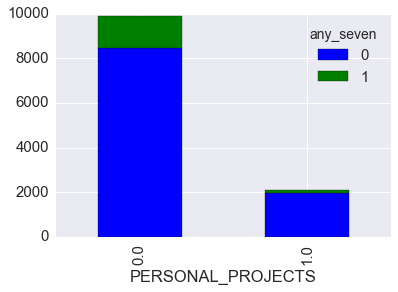

In [18]:
# Any user who has a PERSONAL_PROJECTS creation source is not likely to be an adopted user.
data.groupby(['PERSONAL_PROJECTS', 'any_seven'])['any_seven'].count().\
 unstack('any_seven').plot(kind='bar', stacked=True)

In [26]:
#Some code to compute change in entropy from using a feature

#Computes fraction of the list that has the val.
def prob(lst, val):
    L = len(lst)
    if L > 0:
        p = round(float(len(lst[lst==val]))/L, 3)
    else:
        p = 0
    return p

#Determines the Entropy Contribution from a given probability
def entropyContribution(p):
    if p != 0:
        return round(-p*math.log(p, 2), 3)
    else:
        return 0
    
#Computes the entropy given a binary probability - 1 or 0
def binaryEntropy(p):
    S = entropyContribution(p) + entropyContribution(1-p)
    return S

In [27]:
def computeEntropyChange(item):
    initialEntropy = binaryEntropy(prob(data.any_seven, 1))
    finalEntropy =  prob(data[item], 1)*binaryEntropy(prob(data[data[item]==1].any_seven, 1)) + \
      prob(data[item], 0)*binaryEntropy(prob(data[data[item]==0].any_seven, 1))
    print item, initialEntropy-finalEntropy


In [29]:
for item in feature_cols:
    computeEntropyChange(item)

mailing_list 0.002579
drip 0.00151
invited 0.00318
GUEST_INVITE 0.00382
ORG_INVITE 0.003173
PERSONAL_PROJECTS 0.007552
SIGNUP 0.002346
SIGNUP_GOOGLE_AUTH 0.00273


# Logistic Regression Comparison

In [39]:
from sklearn.linear_model import LogisticRegression

In [42]:
logreg = LogisticRegression(C=1e9)
logreg.fit(X, y)

LogisticRegression(C=1000000000.0, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

In [47]:
for item in range(len(feature_cols)):
    print feature_cols[item], round(logreg.coef_[0][item] ,3)


mailing_list 0.051
drip 0.005
invited -0.164
GUEST_INVITE 0.063
ORG_INVITE -0.227
PERSONAL_PROJECTS -0.964
SIGNUP -0.302
SIGNUP_GOOGLE_AUTH -0.093


In [48]:
# Interesting that models have the same mean squared error 
from sklearn import metrics

print "Decision Tree : " , metrics.mean_squared_error(y, tree.predict(X))
print "Logistic Regression : " , metrics.mean_squared_error(y, logreg.predict(X))

Decision Tree :  0.1335
Logistic Regression :  0.1335
